# Big Data Analytics of Hotel Bookings

## 1. Data Import

In [99]:
# import modules
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession

# build spark session and spark context
spark = SparkSession.builder \
        .master("local[4]") \
        .appName("hotel") \
        .getOrCreate()
sc = spark.sparkContext

df = spark.read.csv('hotel_bookings.csv',  inferSchema=True, header = True)

## 2. Exploratory Data Analysis

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import *
import pyspark.sql.functions as f
import numpy as np
import pandas as pd

In [101]:
df.select(['is_canceled']).describe().show()

+-------+-------------------+
|summary|        is_canceled|
+-------+-------------------+
|  count|             119390|
|   mean|0.37041628277075134|
| stddev| 0.4829182265925992|
|    min|                  0|
|    max|                  1|
+-------+-------------------+



In [102]:
df.groupBy('is_canceled').count().show()

+-----------+-----+
|is_canceled|count|
+-----------+-----+
|          1|44224|
|          0|75166|
+-----------+-----+



In [103]:
# descriptives of numeric variables
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']
df.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
is_canceled,119390,0.37041628277075134,0.4829182265925992,0,1
lead_time,119390,104.01141636652986,106.86309704798789,0,737
arrival_date_year,119390,2016.156554150264,0.7074759445197123,2015,2017
arrival_date_week_number,119390,27.16517296255968,13.605138355497637,1,53
arrival_date_day_of_month,119390,15.798241058715135,8.780829470578368,1,31
stays_in_weekend_nights,119390,0.9275986263506156,0.9986134945978752,0,19
stays_in_week_nights,119390,2.500301532791691,1.9082856150479115,0,50
adults,119390,1.8564033838679956,0.5792609988327535,0,55
babies,119390,0.007948739425412514,0.09743619130126421,0,10


In [104]:
# average daily rate (ADR): defined by dividing the sum of all lodging transactions by the total number of staying nights
# Number of stays in the weekday/weekend
# lead_time: Number of days that elapsed between the entering date of the booking into the PMS and the arrival date
df.select(['adr','stays_in_weekend_nights', 'stays_in_week_nights', 'lead_time']).describe().show()

+-------+------------------+-----------------------+--------------------+------------------+
|summary|               adr|stays_in_weekend_nights|stays_in_week_nights|         lead_time|
+-------+------------------+-----------------------+--------------------+------------------+
|  count|            119390|                 119390|              119390|            119390|
|   mean|101.83112153446551|     0.9275986263506156|   2.500301532791691|104.01141636652986|
| stddev|50.535790285548764|     0.9986134945978752|  1.9082856150479115|106.86309704798789|
|    min|             -6.38|                      0|                   0|                 0|
|    max|            5400.0|                     19|                  50|               737|
+-------+------------------+-----------------------+--------------------+------------------+



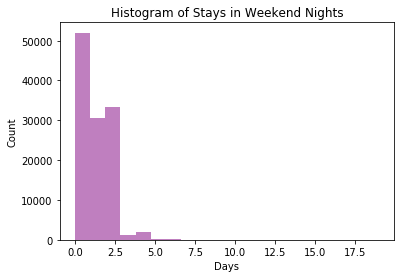

In [105]:
# value counts of stays_in_weekend_nights
df_stayweekend = [val.stays_in_weekend_nights for val in df.select('stays_in_weekend_nights').collect()] 

# Histogram of stay_in_weekend_nights
num_bins = 20
n, bins, patches = plt.hist(df_stayweekend, num_bins, facecolor='purple', alpha=0.5)

# Add title and axis names
plt.title('Histogram of Stays in Weekend Nights')
plt.xlabel('Days')
plt.ylabel('Count')

# Limits for the X axis
# plt.xlim(0,10)

# plt.savefig("Hist_Weekends.png")
plt.show()

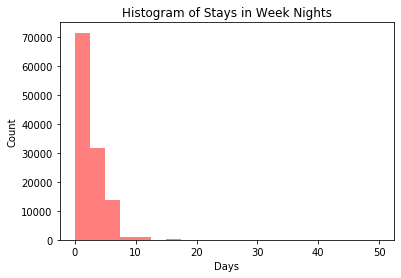

In [106]:
#list of stays_in_week_nights values
df_stayweek = [val.stays_in_week_nights for val in df.select('stays_in_week_nights').collect()] 

#Histogram of stays_in_week_nights
num_bins = 20
n, bins, patches = plt.hist(df_stayweek, num_bins, facecolor='red', alpha=0.5)

# Add title and axis names
plt.title('Histogram of Stays in Week Nights')
plt.xlabel('Days')
plt.ylabel('Count')

plt.savefig("Hist_Weeknights.png")
plt.show()

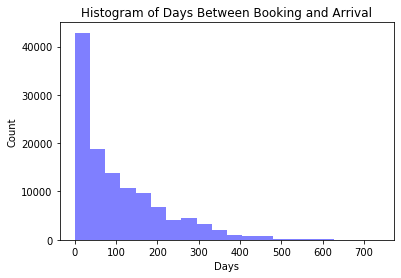

In [107]:
#list of lead_time values
df_lt = [val.lead_time for val in df.select('lead_time').collect()] 

#Histogram of lead_time
num_bins = 20
n, bins, patches = plt.hist(df_lt, num_bins, facecolor='blue', alpha=0.5)

# Add title and axis names
plt.title('Histogram of Days Between Booking and Arrival')
plt.xlabel('Days')
plt.ylabel('Count')

# plt.savefig("Hist_LeadTime.png")
plt.show()

In [108]:
# Whether patrons/customers were adults with children
df.select(['adults', 'children', 'babies']).describe().show()

+-------+------------------+-------------------+--------------------+
|summary|            adults|           children|              babies|
+-------+------------------+-------------------+--------------------+
|  count|            119390|             119390|              119390|
|   mean|1.8564033838679956|0.10388990333874994|0.007948739425412514|
| stddev|0.5792609988327535|0.39856144478644145| 0.09743619130126421|
|    min|                 0|                  0|                   0|
|    max|                55|                 NA|                  10|
+-------+------------------+-------------------+--------------------+



In [109]:
# Arrival month and year to hotel
df.select(['arrival_date_month', 'arrival_date_year']).describe().show()

+-------+------------------+------------------+
|summary|arrival_date_month| arrival_date_year|
+-------+------------------+------------------+
|  count|            119390|            119390|
|   mean|              null| 2016.156554150264|
| stddev|              null|0.7074759445197123|
|    min|             April|              2015|
|    max|         September|              2017|
+-------+------------------+------------------+



In [110]:
# view counts of cancelation by year
df.groupBy('arrival_date_year', 'is_canceled')\
    .count()\
    .sort('arrival_date_year', 'is_canceled')\
    .show()

+-----------------+-----------+-----+
|arrival_date_year|is_canceled|count|
+-----------------+-----------+-----+
|             2015|          0|13854|
|             2015|          1| 8142|
|             2016|          0|36370|
|             2016|          1|20337|
|             2017|          0|24942|
|             2017|          1|15745|
+-----------------+-----------+-----+



In [111]:
#Get counts of cancel or not cancel by hotel type
nocancel_2015 = df.filter((col('arrival_date_year') == '2015') & (col('is_canceled') == 0)).count()
cancel_2015 = df.filter((col('arrival_date_year') == '2015') & (col('is_canceled') == 1)).count()
nocancel_2016 = df.filter((col('arrival_date_year') == '2016') & (col('is_canceled') == 0)).count()
cancel_2016 = df.filter((col('arrival_date_year') == '2016') & (col('is_canceled') == 1)).count()
nocancel_2017 = df.filter((col('arrival_date_year') == '2017') & (col('is_canceled') == 0)).count()
cancel_2017 = df.filter((col('arrival_date_year') == '2017') & (col('is_canceled') == 1)).count()

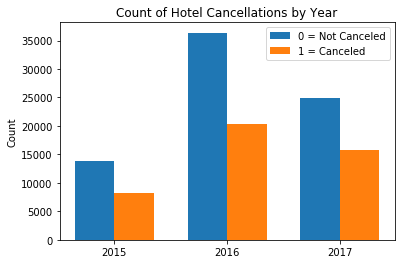

In [112]:
#Visualize cancellations by year

x_year = [val.arrival_date_year for val in df.select('arrival_date_year').distinct().collect()]
labels = x_year
cancel0_count = [nocancel_2015, nocancel_2016, nocancel_2017]
cancel1_count = [cancel_2015, cancel_2016, cancel_2017]

x = np.arange(len(x_year))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, cancel0_count, width, label='0 = Not Canceled')
rects2 = ax.bar(x + width/2, cancel1_count, width, label='1 = Canceled')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Count')
ax.set_title('Count of Hotel Cancellations by Year')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# plt.savefig("Cancel_by_Year.png")
plt.show()

In [113]:
#Indication on if the customer made a deposit to guarantee the booking.
#No Deposit – no deposit was made
#Non Refund – a deposit was made in the value of the total stay cost
#Refundable – a deposit was made with a value under the total cost of stay.

df.groupBy("deposit_type", 'hotel', 'is_canceled').avg('adr').sort("deposit_type", 'hotel', 'is_canceled').show()

+------------+------------+-----------+------------------+
|deposit_type|       hotel|is_canceled|          avg(adr)|
+------------+------------+-----------+------------------+
|  No Deposit|  City Hotel|          0| 105.7526466513691|
|  No Deposit|  City Hotel|          1|112.00739824145536|
|  No Deposit|Resort Hotel|          0| 90.93364290931946|
|  No Deposit|Resort Hotel|          1|112.77001693121677|
|  Non Refund|  City Hotel|          0| 99.77833333333335|
|  Non Refund|  City Hotel|          1| 93.12289551541605|
|  Non Refund|Resort Hotel|          0|  69.8572463768116|
|  Non Refund|Resort Hotel|          1| 66.07261818181843|
|  Refundable|  City Hotel|          0| 78.04166666666667|
|  Refundable|  City Hotel|          1|130.80714285714285|
|  Refundable|Resort Hotel|          0| 68.16483333333333|
|  Refundable|Resort Hotel|          1| 84.84772727272728|
+------------+------------+-----------+------------------+



In [114]:
# view count of cancellation by deposit type
df.groupBy("deposit_type", 'is_canceled').count().sort("deposit_type").show()

+------------+-----------+-----+
|deposit_type|is_canceled|count|
+------------+-----------+-----+
|  No Deposit|          1|29694|
|  No Deposit|          0|74947|
|  Non Refund|          0|   93|
|  Non Refund|          1|14494|
|  Refundable|          1|   36|
|  Refundable|          0|  126|
+------------+-----------+-----+



In [115]:
# heck count of cancellations for deposit type
df.groupBy("deposit_type", 'hotel', 'is_canceled').count().sort("deposit_type", 'hotel', 'is_canceled').show()

+------------+------------+-----------+-----+
|deposit_type|       hotel|is_canceled|count|
+------------+------------+-----------+-----+
|  No Deposit|  City Hotel|          0|46198|
|  No Deposit|  City Hotel|          1|20244|
|  No Deposit|Resort Hotel|          0|28749|
|  No Deposit|Resort Hotel|          1| 9450|
|  Non Refund|  City Hotel|          0|   24|
|  Non Refund|  City Hotel|          1|12844|
|  Non Refund|Resort Hotel|          0|   69|
|  Non Refund|Resort Hotel|          1| 1650|
|  Refundable|  City Hotel|          0|    6|
|  Refundable|  City Hotel|          1|   14|
|  Refundable|Resort Hotel|          0|  120|
|  Refundable|Resort Hotel|          1|   22|
+------------+------------+-----------+-----+



In [116]:
#Data frame filtered by 0/1
df_cancel0 = df.filter(col('is_canceled') == 0)
df_cancel1 = df.filter(col('is_canceled') == 1)

In [117]:
#Deposit types
deposit0 = df_cancel0.groupBy('deposit_type').count().sort('deposit_type')
deposit1 = df_cancel1.groupBy('deposit_type').count().sort('deposit_type')

#List of counts for non-cancelled deposity types
deposit0_list = deposit0.select("count").rdd.flatMap(lambda x: x).collect()
deposit0_list

#List of counts for cancelled deposity types
deposit1_list = deposit1.select("count").rdd.flatMap(lambda x: x).collect()
deposit1_list

[29694, 14494, 36]

In [118]:
x_deposit = [val.deposit_type for val in df.select('deposit_type').groupBy('deposit_type').count().collect()]
x_deposit.sort()
print(x_deposit)

['No Deposit', 'Non Refund', 'Refundable']


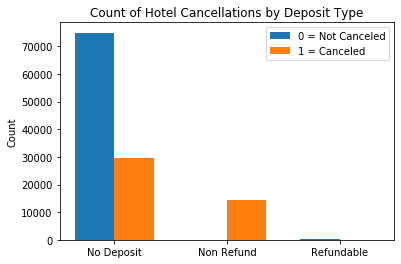

In [119]:
#visualize deposit_type cancellation

#Sorted in this order: 'Contract', 'Group', 'Transient', 'Transient-Party'
labels = x_deposit
cancel0_count = deposit0_list
cancel1_count = deposit1_list

x = np.arange(len(x_deposit))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, cancel0_count, width, label='0 = Not Canceled')
rects2 = ax.bar(x + width/2, cancel1_count, width, label='1 = Canceled')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Count')
ax.set_title('Count of Hotel Cancellations by Deposit Type')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# plt.savefig("Cancel_by_Deposit.png")
plt.show()

In [120]:
#Type of booking, assuming one of four categories
#Contract - when the booking has an allotment or other type of contract associated to it
#Group – when the booking is associated to a group
#Transient – when the booking is not part of a group or contract, and is not associated to other transient booking
#Transient-party – when the booking is transient, but is associated to at least other transient booking

df.groupBy("customer_type", 'is_canceled').count().sort('customer_type', 'is_canceled').show()

+---------------+-----------+-----+
|  customer_type|is_canceled|count|
+---------------+-----------+-----+
|       Contract|          0| 2814|
|       Contract|          1| 1262|
|          Group|          0|  518|
|          Group|          1|   59|
|      Transient|          0|53099|
|      Transient|          1|36514|
|Transient-Party|          0|18735|
|Transient-Party|          1| 6389|
+---------------+-----------+-----+



In [121]:
# count distinct levels of customer type
x_customer = [val.customer_type for val in df.select('customer_type').groupBy('customer_type').count().collect()]
x_customer.sort()
print(x_customer)

['Contract', 'Group', 'Transient', 'Transient-Party']


In [122]:
# count of non-cancelled hotel booking by customer type
customer0 = df_cancel0.groupBy('customer_type').count().sort('customer_type')
customer0.show()

+---------------+-----+
|  customer_type|count|
+---------------+-----+
|       Contract| 2814|
|          Group|  518|
|      Transient|53099|
|Transient-Party|18735|
+---------------+-----+



In [123]:
# count of cancelled hotel booking by customer type
customer1 = df_cancel1.groupBy('customer_type').count().sort('customer_type')
customer1.show()

+---------------+-----+
|  customer_type|count|
+---------------+-----+
|       Contract| 1262|
|          Group|   59|
|      Transient|36514|
|Transient-Party| 6389|
+---------------+-----+



In [124]:
# list of count of count of non-cancelled hotel booking by customer type
customer0_list = customer0.select("count").rdd.flatMap(lambda x: x).collect()

# list of count of count of cancelled hotel booking by customer type
customer1_list = customer1.select("count").rdd.flatMap(lambda x: x).collect()

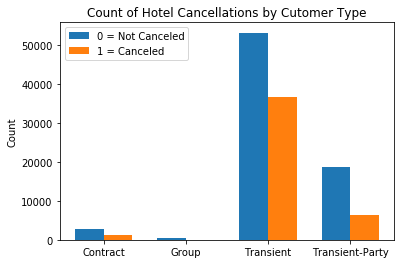

In [125]:
#visualize customer_type cancellation

#Sorted in this order: 'Contract', 'Group', 'Transient', 'Transient-Party'
labels = x_customer
cancel0_count = customer0_list
cancel1_count = customer1_list

x = np.arange(len(x_customer))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, cancel0_count, width, label='0 = Not Canceled')
rects2 = ax.bar(x + width/2, cancel1_count, width, label='1 = Canceled')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Count')
ax.set_title('Count of Hotel Cancellations by Cutomer Type')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# plt.savefig("Cancel_by_CustomerType.png")
plt.show()

In [126]:
# Average hotel daily average rates per month by hotel
df.groupBy('arrival_date_month','hotel').avg('adr').sort('arrival_date_month','hotel').show()

+------------------+------------+------------------+
|arrival_date_month|       hotel|          avg(adr)|
+------------------+------------+------------------+
|             April|  City Hotel|111.25183823529385|
|             April|Resort Hotel| 77.84949570518152|
|            August|  City Hotel|114.68045530446365|
|            August|Resort Hotel|186.79057417245596|
|          December|  City Hotel| 88.82630687318493|
|          December|Resort Hotel| 68.98422960725051|
|          February|  City Hotel| 85.08827794561917|
|          February|Resort Hotel| 55.17193038994517|
|           January|  City Hotel| 82.62898554603852|
|           January|Resort Hotel|49.461883264933924|
|              July|  City Hotel|110.73429154302673|
|              July|Resort Hotel|155.18129892849296|
|              June|  City Hotel|119.07434127185202|
|              June|Resort Hotel|110.44474876847272|
|             March|  City Hotel| 92.64311551563968|
|             March|Resort Hotel|57.5201468824

In [127]:
# Hotel cancellation counts by hotel atype and month
df.groupBy('arrival_date_month','hotel', 'is_canceled')\
    .count().sort('arrival_date_month','hotel', 'is_canceled').show()

+------------------+------------+-----------+-----+
|arrival_date_month|       hotel|is_canceled|count|
+------------------+------------+-----------+-----+
|             April|  City Hotel|          0| 4015|
|             April|  City Hotel|          1| 3465|
|             April|Resort Hotel|          0| 2550|
|             April|Resort Hotel|          1| 1059|
|            August|  City Hotel|          0| 5381|
|            August|  City Hotel|          1| 3602|
|            August|Resort Hotel|          0| 3257|
|            August|Resort Hotel|          1| 1637|
|          December|  City Hotel|          0| 2392|
|          December|  City Hotel|          1| 1740|
|          December|Resort Hotel|          0| 2017|
|          December|Resort Hotel|          1|  631|
|          February|  City Hotel|          0| 3064|
|          February|  City Hotel|          1| 1901|
|          February|Resort Hotel|          0| 2308|
|          February|Resort Hotel|          1|  795|
|           

In [128]:
# unordered original appeared months
months_label = [val.arrival_date_month for val in df.select('arrival_date_month').distinct().collect()] 
months_label.sort()
months_label

['April',
 'August',
 'December',
 'February',
 'January',
 'July',
 'June',
 'March',
 'May',
 'November',
 'October',
 'September']

In [129]:
# reorder months
months_label[0] = '04'
months_label[1] = '08'
months_label[2] = '12'
months_label[3] = '02'
months_label[4] = '01'
months_label[5] = '07'
months_label[6] = '06'
months_label[7] = '03'
months_label[8] = '05'
months_label[9] = '11'
months_label[10] = '10'
months_label[11] = '09'
months_label

['04', '08', '12', '02', '01', '07', '06', '03', '05', '11', '10', '09']

In [130]:
months_label.sort()
print(months_label)

['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']


In [131]:
# reorder2
months_label[0] = 'January'
months_label[1] = 'February'
months_label[2] = 'March'
months_label[3] = 'April'
months_label[4] = 'May'
months_label[5] = 'June'
months_label[6] = 'July'
months_label[7] = 'August'
months_label[8] = 'September'
months_label[9] = 'October'
months_label[10] = 'November'
months_label[11] = 'December'
months_label

['January',
 'February',
 'March',
 'April',
 'May',
 'June',
 'July',
 'August',
 'September',
 'October',
 'November',
 'December']

In [132]:
# count of non-cancellation by month
months_cancel0 = df_cancel0.groupBy('arrival_date_month')\
    .count().sort('arrival_date_month')
months_cancel0.show()

+------------------+-----+
|arrival_date_month|count|
+------------------+-----+
|             April| 6565|
|            August| 8638|
|          December| 4409|
|          February| 5372|
|           January| 4122|
|              July| 7919|
|              June| 6404|
|             March| 6645|
|               May| 7114|
|          November| 4672|
|           October| 6914|
|         September| 6392|
+------------------+-----+



In [133]:
# Get list of counts for months when not canceled
month0_list = months_cancel0.select("count").rdd.flatMap(lambda x: x).collect()

In [134]:
# Reorder month canceled list counts for Jan-Dec
month0_list2 = [0] * 12
month0_list2[0] = month0_list[4]  #Apr spot for Jan
month0_list2[1] = month0_list[3]  #Aug spot for Feb
month0_list2[2] = month0_list[7]  #Dec spot for Mar
month0_list2[3] = month0_list[0]  #Feb spot for Apr
month0_list2[4] = month0_list[8]  #Jan spot for May
month0_list2[5] = month0_list[6]  #Jul spot for Jun
month0_list2[6] = month0_list[5]  #Jun spot for Jul
month0_list2[7] = month0_list[1]  #Mar spot for Aug
month0_list2[8] = month0_list[11]  #May spot for Sep
month0_list2[9] = month0_list[10]  #Nov spot for Oct
month0_list2[10] = month0_list[9]  #Oct spot for Nov
month0_list2[11] = month0_list[2]  #Sep spot for Dec
month0_list2

# Now list of counts matches Jan-Dec

[4122, 5372, 6645, 6565, 7114, 6404, 7919, 8638, 6392, 6914, 4672, 4409]

In [135]:
# counts of cancelled booking by month
months_cancel1 = df_cancel1.groupBy('arrival_date_month')\
    .count().sort('arrival_date_month')
months_cancel1.show()

+------------------+-----+
|arrival_date_month|count|
+------------------+-----+
|             April| 4524|
|            August| 5239|
|          December| 2371|
|          February| 2696|
|           January| 1807|
|              July| 4742|
|              June| 4535|
|             March| 3149|
|               May| 4677|
|          November| 2122|
|           October| 4246|
|         September| 4116|
+------------------+-----+



In [136]:
# Get list of counts for months when canceled
month1_list = months_cancel1.select("count").rdd.flatMap(lambda x: x).collect()
month1_list

[4524, 5239, 2371, 2696, 1807, 4742, 4535, 3149, 4677, 2122, 4246, 4116]

In [137]:
# Reorder month canceled list counts for Jan-Dec
month1_list2 = [0] * 12
month1_list2[0] = month1_list[4]  #Apr spot for Jan
month1_list2[1] = month1_list[3]  #Aug spot for Feb
month1_list2[2] = month1_list[7]  #Dec spot for Mar
month1_list2[3] = month1_list[0]  #Feb spot for Apr
month1_list2[4] = month1_list[8]  #Jan spot for May
month1_list2[5] = month1_list[6]  #Jul spot for Jun
month1_list2[6] = month1_list[5]  #Jun spot for Jul
month1_list2[7] = month1_list[1]  #Mar spot for Aug
month1_list2[8] = month1_list[11]  #May spot for Sep
month1_list2[9] = month1_list[10]  #Nov spot for Oct
month1_list2[10] = month1_list[9]  #Oct spot for Nov
month1_list2[11] = month1_list[2]  #Sep spot for Dec
month1_list2

# Now list of counts matches Jan-Dec

[1807, 2696, 3149, 4524, 4677, 4535, 4742, 5239, 4116, 4246, 2122, 2371]

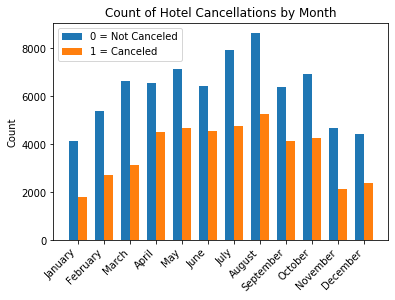

In [138]:
# visualize non cancellations and cancellations by month

# Ordered: Jan, Feb, Mar...
labels = months_label
cancel0_count = month0_list2
cancel1_count = month1_list2

x = np.arange(len(months_label))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, cancel0_count, width, label='0 = Not Canceled')
rects2 = ax.bar(x + width/2, cancel1_count, width, label='1 = Canceled')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Count')
ax.set_title('Count of Hotel Cancellations by Month')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation = 45, ha="right")
ax.legend()

# plt.savefig("Cancel_by_Month.png")
plt.show()


In [139]:
# Count of cancellations by hotel type and year
# 2015-2017
df.groupBy('arrival_date_year','hotel', 'is_canceled')\
    .count().sort('arrival_date_year','hotel', 'is_canceled').show()

+-----------------+------------+-----------+-----+
|arrival_date_year|       hotel|is_canceled|count|
+-----------------+------------+-----------+-----+
|             2015|  City Hotel|          0| 7678|
|             2015|  City Hotel|          1| 6004|
|             2015|Resort Hotel|          0| 6176|
|             2015|Resort Hotel|          1| 2138|
|             2016|  City Hotel|          0|22733|
|             2016|  City Hotel|          1|15407|
|             2016|Resort Hotel|          0|13637|
|             2016|Resort Hotel|          1| 4930|
|             2017|  City Hotel|          0|15817|
|             2017|  City Hotel|          1|11691|
|             2017|Resort Hotel|          0| 9125|
|             2017|Resort Hotel|          1| 4054|
+-----------------+------------+-----------+-----+



In [140]:
# count of cancellation by hotel
df.groupBy('hotel').count().select('hotel', f.col('count')).show()

+------------+-----+
|       hotel|count|
+------------+-----+
|  City Hotel|79330|
|Resort Hotel|40060|
+------------+-----+



In [141]:
# Get counts of cancel or not cancel by hotel type
resort_0 = df.filter((col('hotel') == 'Resort Hotel') & (col('is_canceled') == 0)).count()
resort_1 = df.filter((col('hotel') == 'Resort Hotel') & (col('is_canceled') == 1)).count()
city_0 = df.filter((col('hotel') == 'City Hotel') & (col('is_canceled') == 0)).count()
city_1 = df.filter((col('hotel') == 'City Hotel') & (col('is_canceled') == 1)).count()

In [142]:
# cancellations by hotel type in dataframe
df.groupBy('hotel', 'is_canceled').count().show()

+------------+-----------+-----+
|       hotel|is_canceled|count|
+------------+-----------+-----+
|Resort Hotel|          0|28938|
|  City Hotel|          0|46228|
|Resort Hotel|          1|11122|
|  City Hotel|          1|33102|
+------------+-----------+-----+



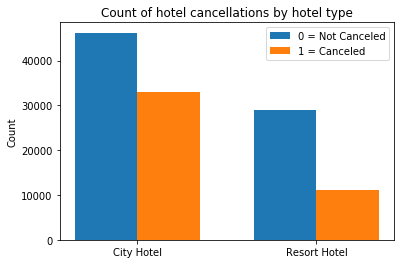

In [143]:
# to visualize, we use matplotlib
# Hotel cancellations by hotel type

# y_iscancel = [val.is_canceled for val in df.select('is_canceled').distinct().collect()]   #gets [0,1]
x_hoteltype = [val.hotel for val in df.select('hotel').groupBy('hotel').count().collect()]

labels = ['City Hotel', 'Resort Hotel']
cancel0_count = [city_0, resort_0]
cancel1_count = [city_1, resort_1]

x = np.arange(len(x_hoteltype))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, cancel0_count, width, label='0 = Not Canceled')
rects2 = ax.bar(x + width/2, cancel1_count, width, label='1 = Canceled')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Count')
ax.set_title('Count of hotel cancellations by hotel type')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.savefig("Cancel_by_HotelType.png")
plt.show()

## 3. Preprocessing

In [144]:
from pyspark.sql.functions import col

# replace the strings "NULL" and "NA" with null value
df_withNull = df.replace('NULL', None).replace('NA', None)

# replace null values in 'children' to 0 since there are only 4
df2 = df_withNull.fillna({'children':0})

# replace 'children' datatype to int
df2 = df2.withColumn('children', col('children').cast("Int"))
df2 = df2.withColumn('arrival_date_year', col('arrival_date_year').cast("Int")-2015)

# drop 'company' and 'agent' due to high null count
df2 = df2.drop('agent', 'company','country', 'arrival_date_week_number', 'reservation_status', 'reservation_status_date')

In [145]:
# specifying which columns to encode in which way
from pyspark.ml.feature import OneHotEncoder, OneHotEncoderModel, Normalizer
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.mllib.linalg import Vectors

# list of columns to numerically encode
col_string=['hotel', 'meal','market_segment',
            'distribution_channel','reserved_room_type','assigned_room_type',
            'deposit_type','customer_type']
col_stringwmonth = col_string+['arrival_date_month']

# list of new column names being changed into numeric
col_num=[x+"_NUMERIC" for x in col_string]

# list of columns being one-hot encoded
col_oh=[x+"_oh" for x in col_string]

# list of columns to normalize
norm_to_columns = ['lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 
                'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'adr', 
                'required_car_parking_spaces', 'total_of_special_requests']

#### Numerical Encoding

In [146]:
# combine string index encoding on each specified column
all_string_index = [StringIndexer(inputCol=column, outputCol=column+"_NUMERIC").fit(df2) for column in col_stringwmonth]

#### One Hot Encoding

In [147]:
# ohe columns
ohe = OneHotEncoder(dropLast=False).setInputCols(col_num).setOutputCols(col_oh)

#### Normalization

In [148]:
# combine all to-norm columns into one vector named "norm_features"
assembler = VectorAssembler(inputCols=norm_to_columns, outputCol="to_norm_features")

# normalize continuous columns
normalizer = Normalizer(inputCol="to_norm_features", outputCol="norm_features", p=1.0)

In [149]:
# specify final variables
final_variables = ['lead_time', 
                   'arrival_date_year',
                   'arrival_date_day_of_month',
                   'stays_in_weekend_nights',
                   'stays_in_week_nights',
                   'adults',
                   'children', 
                   'babies',
                   'is_repeated_guest',
                   'previous_cancellations',
                   'previous_bookings_not_canceled',
                   'booking_changes',
                   'days_in_waiting_list',
                   'adr',
                   'required_car_parking_spaces',
                   'total_of_special_requests',
                   'arrival_date_month_NUMERIC',
                   'distribution_channel_oh',
                   'customer_type_oh',
                   'market_segment_oh',
                   'reserved_room_type_oh',
                   'assigned_room_type_oh',
                   'meal_oh',
                   'hotel_oh',
                   'deposit_type_oh']

In [150]:
# combine all feature columns (non-label columns) into one vector named "feature"
assembler2 = VectorAssembler(inputCols=final_variables, outputCol="features")

#### Construct Pipeline

In [151]:
# construct pipeline
pipeline = Pipeline(stages=all_string_index + [ohe, assembler, normalizer, assembler2])
df3 = pipeline.fit(df2).transform(df2)

In [152]:
# convert to RDD
dataRdd = df3.select(col("is_canceled").alias("label"), col("features")).rdd.map(tuple)

#### Construct LabeledPoint

In [153]:
from pyspark.mllib.regression import LabeledPoint

# map features as floats, then input all into a DenseVector, as well as mapping labels as floats
# then map into LabeledPoint object
lp = dataRdd.map(lambda row: (float(row[0]), Vectors.dense([float(c) for c in row[1]])))\
            .map(lambda row: LabeledPoint(row[0], row[1]))

#### Split Dataset

In [154]:
# 70/30 test train split
seed = 314
train, test = lp.randomSplit([0.7, 0.3], seed=seed)

# store test and train counts
test_count = test.count()
train_count = train.count()

from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.mllib.evaluation import BinaryClassificationMetrics

## 4. Model Fitting

### Logistic Regression

In [155]:
from pyspark.mllib.classification import LogisticRegressionWithLBFGS

# train logistic regression model with training data
model = LogisticRegressionWithLBFGS.train(train)

In [156]:
# Evaluating the model on test data
labelsAndPreds_te = test.map(lambda p: (p.label, float(model.predict(p.features))))
accuracy_te = 1.0 * labelsAndPreds_te.filter(lambda pl: pl[0] == pl[1]).count() / test_count
print('model accuracy (test): {}'.format(accuracy_te))

model accuracy (test): 0.8138002579487467


#### Logistic with intercept

In [157]:
model_lr_int = LogisticRegressionWithLBFGS.train(train, intercept=True)

In [158]:
# Evaluating the model on test data
labelsAndPreds_te_int = test.map(lambda p: (p.label, model_lr_int.predict(p.features)))
accuracy_te_int = 1.0 * labelsAndPreds_te_int.filter(lambda pl: pl[0] == pl[1]).count() / test_count
print('model accuracy (test): {}'.format(accuracy_te_int))

model accuracy (test): 0.8132394998037347


#### Logistic with interations=10

In [159]:
model_lr_it10 = LogisticRegressionWithLBFGS.train(train, iterations=10)

In [160]:
# Evaluating the model on test data
labelsAndPreds_te_it10 = test.map(lambda p: (p.label, model_lr_it10.predict(p.features)))
accuracy_te_it10 = 1.0 * labelsAndPreds_te_it10.filter(lambda pl: pl[0] == pl[1]).count() / test_count
print('model accuracy (test): {}'.format(accuracy_te_it10))

model accuracy (test): 0.80093085852072


#### Logistic with intercept and iterations=10

In [194]:
model_lr_it10_int = LogisticRegressionWithLBFGS.train(train, iterations=300, intercept=True)

In [195]:
# Evaluating the model on test data
labelsAndPreds_te_it10_int = test.map(lambda p: (p.label, float(model_lr_it10_int.predict(p.features))))
accuracy_te_it10_int = 1.0 * labelsAndPreds_te_it10_int.filter(lambda pl: pl[0] == pl[1]).count() / test_count
print('model accuracy (test): {}'.format(accuracy_te_it10_int))

model accuracy (test): 0.8133236135254864


In [163]:
# calculate confusion matrix and AUROC for base logistic model

metrix1 = MulticlassMetrics(labelsAndPreds_te)
con_metrix1=metrix1.confusionMatrix().toArray()

print('Confusion matrix')
print(con_metrix1)

FN1=metrix1.falsePositiveRate(0.0)
FP1=metrix1.falsePositiveRate(1.0)

print('False negative rate {:2.2%}'.format(FN1))
print('False positive rate {:2.2%}'.format(FP1))

precision1=metrix1.precision(1.0)
recall1=metrix1.recall(1.0)

print('Precision(TP/all positives) {:2.2%}'.format(precision1))
print('Recall(TP/all positive ground truth) {:0.2%}'.format(recall1))


metrics_tr1 = BinaryClassificationMetrics(labelsAndPreds_te)

print("Area under PR for Linear regression = {:2.2%}".format(metrics_tr1.areaUnderPR))

# Area under ROC curve for training data
print("Area under ROC for Linear regression = {:2.2%}".format(metrics_tr1.areaUnderROC))

Confusion matrix
[[20766.  4961.]
 [ 1680.  8259.]]
False negative rate 16.90%
False positive rate 19.28%
Precision(TP/all positives) 62.47%
Recall(TP/all positive ground truth) 83.10%
Area under PR for Linear regression = 59.55%
Area under ROC for Linear regression = 81.91%


In [164]:
# calculate confusion matrix and AUROC for base logistic model

metrix1 = MulticlassMetrics(labelsAndPreds_te_it10_int)
con_metrix1=metrix1.confusionMatrix().toArray()

print('Confusion matrix')
print(con_metrix1)

FN1=metrix1.falsePositiveRate(0.0)
FP1=metrix1.falsePositiveRate(1.0)

print('False negative rate {:2.2%}'.format(FN1))
print('False positive rate {:2.2%}'.format(FP1))

precision1=metrix1.precision(1.0)
recall1=metrix1.recall(1.0)

print('Precision(TP/all positives) {:2.2%}'.format(precision1))
print('Recall(TP/all positive ground truth) {:0.2%}'.format(recall1))


metrics_tr1 = BinaryClassificationMetrics(labelsAndPreds_te)

print("Area under PR for Linear regression = {:2.2%}".format(metrics_tr1.areaUnderPR))

# Area under ROC curve for training data
print("Area under ROC for Linear regression = {:2.2%}".format(metrics_tr1.areaUnderROC))

Confusion matrix
[[20249.  4923.]
 [ 2197.  8297.]]
False negative rate 20.94%
False positive rate 19.56%
Precision(TP/all positives) 62.76%
Recall(TP/all positive ground truth) 79.06%
Area under PR for Linear regression = 59.55%
Area under ROC for Linear regression = 81.91%


### Save and load SVM file

In [165]:
from pyspark.mllib.util import MLUtils
# converting to LibSVM file (only run once)
# MLUtils.saveAsLibSVMFile(lp, "libsvm.txt")

In [166]:
data = MLUtils.loadLibSVMFile(sc, 'libsvm.txt')
data.take(1)

[LabeledPoint(1.0, (79,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78],[290.0,3.0,1.0,1.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,62.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]))]

In [167]:
# 70/30 test train split for libsvm data
seed = 314
train_sparse, test_sparse = data.randomSplit([0.7, 0.3], seed=seed)

### Decision Tree

In [168]:
from pyspark.mllib.tree import DecisionTree

model_dt1 = DecisionTree.trainClassifier(train_sparse, 2, {})
# Evaluate model on test instances and compute test error
predictions = model_dt1.predict(test_sparse.map(lambda x: x.features))
labelsAndPreds_te2_1 = test_sparse.map(lambda lp: lp.label).zip(predictions)
# labelsAndPreds_te3 = test_sparse.map(lambda p: (p.label, float(model_rf.predict(p.features))))


accuracy_te_dt1 = 1.0 * labelsAndPreds_te2_1.filter(lambda pl: pl[0] == pl[1]).count() / test_count
print('model accuracy (test): {}'.format(accuracy_te_dt1))


model accuracy (test): 0.8061739471765828


In [169]:
model_dt2 = DecisionTree.trainClassifier(train_sparse, 2, {}, maxDepth=10)
# Evaluate model on test instances and compute test error
predictions = model_dt2.predict(test_sparse.map(lambda x: x.features))
labelsAndPreds_te2_2 = test_sparse.map(lambda lp: lp.label).zip(predictions)
# labelsAndPreds_te3 = test_sparse.map(lambda p: (p.label, float(model_rf.predict(p.features))))


accuracy_te_dt2 = 1.0 * labelsAndPreds_te2_2.filter(lambda pl: pl[0] == pl[1]).count() / test_count
print('model accuracy (test): {}'.format(accuracy_te_dt2))


model accuracy (test): 0.8236415633937083


In [170]:
model_dt3 = DecisionTree.trainClassifier(train_sparse, 2, {}, maxDepth=20)
# Evaluate model on test instances and compute test error
predictions = model_dt3.predict(test_sparse.map(lambda x: x.features))
labelsAndPreds_te2_3 = test_sparse.map(lambda lp: lp.label).zip(predictions)
# labelsAndPreds_te3 = test_sparse.map(lambda p: (p.label, float(model_rf.predict(p.features))))


accuracy_te_dt2 = 1.0 * labelsAndPreds_te2_3.filter(lambda pl: pl[0] == pl[1]).count() / test_count
print('model accuracy (test): {}'.format(accuracy_te_dt2))


model accuracy (test): 0.8334267930241687


In [171]:
model_dt4 = DecisionTree.trainClassifier(train_sparse, 2, {}, maxDepth=30)
# Evaluate model on test instances and compute test error
predictions = model_dt4.predict(test_sparse.map(lambda x: x.features))
labelsAndPreds_te2_5 = test_sparse.map(lambda lp: lp.label).zip(predictions)
# labelsAndPreds_te3 = test_sparse.map(lambda p: (p.label, float(model_rf.predict(p.features))))


accuracy_te_dt2 = 1.0 * labelsAndPreds_te2_5.filter(lambda pl: pl[0] == pl[1]).count() / test_count
print('model accuracy (test): {}'.format(accuracy_te_dt2))


model accuracy (test): 0.824230359445971


#### Evaluation of base model

In [198]:
# calculate confusion matrix and AUROC for Decision Tree iter=5

metrix_dt1 = MulticlassMetrics(labelsAndPreds_te2_1)
con_metrix_dt1=metrix_dt1.confusionMatrix().toArray()

print('Confusion matrix')
print(con_metrix_rf1)

FN2=metrix_dt1.falsePositiveRate(0.0)
FP2=metrix_dt1.falsePositiveRate(1.0)

print('False negative rate {:2.2%}'.format(FN2))
print('False positive rate {:2.2%}'.format(FP2))

precision2=metrix_dt1.precision(1.0)
recall2=metrix_dt1.recall(1.0)
f1score2=(2*precision2*recall2) / (precision2+recall2)

print('Precision(TP/all positives) {:2.2%}'.format(precision2))
print('Recall(TP/all positive ground truth) {:0.2%}'.format(recall2))
print('F1 Score(2*Precision*Recall/(Precision+Recall)) {:0.2%}'.format(f1score2))


metrics_tr2 = BinaryClassificationMetrics(labelsAndPreds_te2_1)

print("Area under PR for Linear regression = {:2.2%}".format(metrics_tr2.areaUnderPR))

# Area under ROC curve for training data
print("Area under ROC for Linear regression = {:2.2%}".format(metrics_tr2.areaUnderROC))

Confusion matrix
[[20596.  5033.]
 [ 1973.  8157.]]
False negative rate 19.48%
False positive rate 19.64%
Precision(TP/all positives) 61.84%
Recall(TP/all positive ground truth) 80.52%
F1 Score(2*Precision*Recall/(Precision+Recall)) 69.96%
Area under PR for Linear regression = 58.58%
Area under ROC for Linear regression = 80.44%


In [199]:
# calculate confusion matrix and AUROC for Decision Tree iter=10

metrix_dt1 = MulticlassMetrics(labelsAndPreds_te2_2)
con_metrix_dt1=metrix_dt1.confusionMatrix().toArray()

print('Confusion matrix')
print(con_metrix_rf1)

FN2=metrix_dt1.falsePositiveRate(0.0)
FP2=metrix_dt1.falsePositiveRate(1.0)

print('False negative rate {:2.2%}'.format(FN2))
print('False positive rate {:2.2%}'.format(FP2))

precision2=metrix_dt1.precision(1.0)
recall2=metrix_dt1.recall(1.0)
f1score2=(2*precision2*recall2) / (precision2+recall2)

print('Precision(TP/all positives) {:2.2%}'.format(precision2))
print('Recall(TP/all positive ground truth) {:0.2%}'.format(recall2))
print('F1 Score(2*Precision*Recall/(Precision+Recall)) {:0.2%}'.format(f1score2))


metrics_tr2 = BinaryClassificationMetrics(labelsAndPreds_te2_2)

print("Area under PR for Linear regression = {:2.2%}".format(metrics_tr2.areaUnderPR))

# Area under ROC curve for training data
print("Area under ROC for Linear regression = {:2.2%}".format(metrics_tr2.areaUnderROC))

Confusion matrix
[[20596.  5033.]
 [ 1973.  8157.]]
False negative rate 15.98%
False positive rate 18.58%
Precision(TP/all positives) 63.72%
Recall(TP/all positive ground truth) 84.02%
F1 Score(2*Precision*Recall/(Precision+Recall)) 72.48%
Area under PR for Linear regression = 60.87%
Area under ROC for Linear regression = 82.72%


In [200]:
# calculate confusion matrix and AUROC for Decision Tree iter=20

metrix_dt1 = MulticlassMetrics(labelsAndPreds_te2_3)
con_metrix_dt1=metrix_dt1.confusionMatrix().toArray()

print('Confusion matrix')
print(con_metrix_rf1)

FN2=metrix_dt1.falsePositiveRate(0.0)
FP2=metrix_dt1.falsePositiveRate(1.0)

print('False negative rate {:2.2%}'.format(FN2))
print('False positive rate {:2.2%}'.format(FP2))

precision2=metrix_dt1.precision(1.0)
recall2=metrix_dt1.recall(1.0)
f1score2=(2*precision2*recall2) / (precision2+recall2)

print('Precision(TP/all positives) {:2.2%}'.format(precision2))
print('Recall(TP/all positive ground truth) {:0.2%}'.format(recall2))
print('F1 Score(2*Precision*Recall/(Precision+Recall)) {:0.2%}'.format(f1score2))


metrics_tr2 = BinaryClassificationMetrics(labelsAndPreds_te2_3)

print("Area under PR for Linear regression = {:2.2%}".format(metrics_tr2.areaUnderPR))

# Area under ROC curve for training data
print("Area under ROC for Linear regression = {:2.2%}".format(metrics_tr2.areaUnderROC))

Confusion matrix
[[20596.  5033.]
 [ 1973.  8157.]]
False negative rate 21.45%
False positive rate 14.41%
Precision(TP/all positives) 74.63%
Recall(TP/all positive ground truth) 78.55%
F1 Score(2*Precision*Recall/(Precision+Recall)) 76.54%
Area under PR for Linear regression = 70.39%
Area under ROC for Linear regression = 82.07%


#### Evaluation of best model

In [201]:
# calculate confusion matrix and AUROC for Decision Tree iter=30

metrix_dt1 = MulticlassMetrics(labelsAndPreds_te2_4)
con_metrix_dt1=metrix_dt1.confusionMatrix().toArray()

print('Confusion matrix')
print(con_metrix_rf1)

FN2=metrix_dt1.falsePositiveRate(0.0)
FP2=metrix_dt1.falsePositiveRate(1.0)

print('False negative rate {:2.2%}'.format(FN2))
print('False positive rate {:2.2%}'.format(FP2))

precision2=metrix_dt1.precision(1.0)
recall2=metrix_dt1.recall(1.0)
f1score2=(2*precision2*recall2) / (precision2+recall2)

print('Precision(TP/all positives) {:2.2%}'.format(precision2))
print('Recall(TP/all positive ground truth) {:0.2%}'.format(recall2))
print('F1 Score(2*Precision*Recall/(Precision+Recall)) {:0.2%}'.format(f1score2))


metrics_tr2 = BinaryClassificationMetrics(labelsAndPreds_te2_4)

print("Area under PR for Linear regression = {:2.2%}".format(metrics_tr2.areaUnderPR))

# Area under ROC curve for training data
print("Area under ROC for Linear regression = {:2.2%}".format(metrics_tr2.areaUnderROC))

Confusion matrix
[[20596.  5033.]
 [ 1973.  8157.]]
False negative rate 24.68%
False positive rate 13.62%
Precision(TP/all positives) 76.99%
Recall(TP/all positive ground truth) 75.32%
F1 Score(2*Precision*Recall/(Precision+Recall)) 76.15%
Area under PR for Linear regression = 72.14%
Area under ROC for Linear regression = 80.85%


### Random Forest

In [174]:
from pyspark.mllib.tree import RandomForest, RandomForestModel

# Train a RandomForest model.
#  Empty categoricalFeaturesInfo indicates all features are continuous.
#  Setting featureSubsetStrategy="auto" lets the algorithm choose.
model_rf = RandomForest.trainClassifier(train_sparse, numClasses=2, categoricalFeaturesInfo={},
                                     numTrees=3, featureSubsetStrategy="auto",
                                     impurity='gini', maxDepth=5, maxBins=32)

In [175]:
# Evaluate model on test instances and compute test error
predictions = model_rf.predict(test_sparse.map(lambda x: x.features))
labelsAndPreds_te_rf1 = test_sparse.map(lambda lp: lp.label).zip(predictions)
# labelsAndPreds_te3 = test_sparse.map(lambda p: (p.label, float(model_rf.predict(p.features))))


accuracy_te_rf1 = 1.0 * labelsAndPreds_te_rf1.filter(lambda pl: pl[0] == pl[1]).count() / test_count
print('model accuracy (test): {}'.format(accuracy_te_rf1))

model accuracy (test): 0.7586777322940615


In [176]:
# calculate confusion matrix and AUROC for random forest

metrix_rf1 = MulticlassMetrics(labelsAndPreds_te_rf1)
con_metrix_rf1=metrix_rf1.confusionMatrix().toArray()

print('Confusion matrix')
print(con_metrix_rf1)

FN2=metrix1.falsePositiveRate(0.0)
FP2=metrix1.falsePositiveRate(1.0)

print('False negative rate {:2.2%}'.format(FN2))
print('False positive rate {:2.2%}'.format(FP2))

precision2=metrix_rf1.precision(1.0)
recall2=metrix_rf1.recall(1.0)

print('Precision(TP/all positives) {:2.2%}'.format(precision2))
print('Recall(TP/all positive ground truth) {:0.2%}'.format(recall2))


metrics_tr2 = BinaryClassificationMetrics(labelsAndPreds_te_rf1)

print("Area under PR for Linear regression = {:2.2%}".format(metrics_tr2.areaUnderPR))

# Area under ROC curve for training data
print("Area under ROC for Linear regression = {:2.2%}".format(metrics_tr2.areaUnderROC))

Confusion matrix
[[22498.  8629.]
 [   71.  4561.]]
False negative rate 20.94%
False positive rate 19.56%
Precision(TP/all positives) 33.10%
Recall(TP/all positive ground truth) 99.70%
Area under PR for Linear regression = 33.07%
Area under ROC for Linear regression = 85.79%


### SVM

In [208]:
from pyspark.mllib.classification import SVMWithSGD

model_svm = SVMWithSGD.train(train,iterations=100)

labelsAndPreds_svm1 = test.map(lambda p: (p.label, float(model_svm.predict(p.features))))
accuracy_svm1 = 1.0 * labelsAndPreds_svm1.filter(lambda pl: pl[0] == pl[1]).count() / test_count
print('model accuracy (test): {}'.format(accuracy_svm1))

model accuracy (test): 0.5407671171423765


In [209]:
model_svm_2 = SVMWithSGD.train(train,iterations=100,intercept=True)

labelsAndPreds_svm2 = test.map(lambda p: (p.label, float(model_svm_2.predict(p.features))))
accuracy_svm2 = 1.0 * labelsAndPreds_svm2.filter(lambda pl: pl[0] == pl[1]).count() / test_count
print('model accuracy (test): {}'.format(accuracy_svm2))

model accuracy (test): 0.6374137834352044


In [210]:
model_svm_3 = SVMWithSGD.train(train,iterations=200,intercept=True)

labelsAndPreds_svm3 = test.map(lambda p: (p.label, float(model_svm_3.predict(p.features))))
accuracy_svm3 = 1.0 * labelsAndPreds_svm3.filter(lambda pl: pl[0] == pl[1]).count() / test_count
print('model accuracy (test): {}'.format(accuracy_svm3))

model accuracy (test): 0.6373577076207032


In [211]:
model_svm_4 = SVMWithSGD.train(train,iterations=300,intercept=True)

labelsAndPreds_svm4 = test.map(lambda p: (p.label, float(model_svm_4.predict(p.features))))
accuracy_svm4 = 1.0 * labelsAndPreds_svm4.filter(lambda pl: pl[0] == pl[1]).count() / test_count
print('model accuracy (test): {}'.format(accuracy_svm4))

model accuracy (test): 0.6324510738518477


In [212]:
model_svm_5 = SVMWithSGD.train(train,iterations=200,intercept=False)

labelsAndPreds_svm5 = test.map(lambda p: (p.label, float(model_svm_5.predict(p.features))))
accuracy_svm5 = 1.0 * labelsAndPreds_svm5.filter(lambda pl: pl[0] == pl[1]).count() / test_count
print('model accuracy (test): {}'.format(accuracy_svm5))

model accuracy (test): 0.5456176750967308


In [213]:
model_svm_6 = SVMWithSGD.train(train,iterations=200,intercept=True, regType='l1')

labelsAndPreds_svm6 = test.map(lambda p: (p.label, float(model_svm_6.predict(p.features))))
accuracy_svm6 = 1.0 * labelsAndPreds_svm6.filter(lambda pl: pl[0] == pl[1]).count() / test_count
print('model accuracy (test): {}'.format(accuracy_svm6))

model accuracy (test): 0.6346380306173948


#### Evaluation of Base design

In [214]:
# calculate confusion matrix and AUROC for SVM

metrix3 = MulticlassMetrics(labelsAndPreds_svm1)
con_metrix3=metrix3.confusionMatrix().toArray()

print('Confusion matrix')
print(con_metrix3)

FN3=metrix3.falsePositiveRate(0.0)
FP3=metrix3.falsePositiveRate(1.0)

print('False negative rate {:2.2%}'.format(FN3))
print('False positive rate {:2.2%}'.format(FP3))

precision3=metrix3.precision(1.0)
recall3=metrix3.recall(1.0)
f1score3=(2*precision3*recall3) / (precision3+recall3)

print('Precision(TP/all positives) {:2.2%}'.format(precision3))
print('Recall(TP/all positive ground truth) {:0.2%}'.format(recall3))
print('F1 Score(2*Precision*Recall/(Precision+Recall)) {:0.2%}'.format(f1score3))

metrics_tr3 = BinaryClassificationMetrics(labelsAndPreds_svm1)

print("Area under PR for Linear regression = {:2.2%}".format(metrics_tr3.areaUnderPR))

# Area under ROC curve for training data
print("Area under ROC for Linear regression = {:2.2%}".format(metrics_tr3.areaUnderROC))

Confusion matrix
[[ 7361.  1294.]
 [15085. 11926.]]
False negative rate 55.85%
False positive rate 14.95%
Precision(TP/all positives) 90.21%
Recall(TP/all positive ground truth) 44.15%
F1 Score(2*Precision*Recall/(Precision+Recall)) 59.29%
Area under PR for Linear regression = 86.17%
Area under ROC for Linear regression = 64.60%


#### Evaluation of Worst Design

In [215]:
# calculate confusion matrix and AUROC for SVM

metrix3 = MulticlassMetrics(labelsAndPreds_svm5)
con_metrix3=metrix3.confusionMatrix().toArray()

print('Confusion matrix')
print(con_metrix3)

FN3=metrix3.falsePositiveRate(0.0)
FP3=metrix3.falsePositiveRate(1.0)

print('False negative rate {:2.2%}'.format(FN3))
print('False positive rate {:2.2%}'.format(FP3))

precision3=metrix3.precision(1.0)
recall3=metrix3.recall(1.0)
f1score3=(2*precision3*recall3) / (precision3+recall3)

print('Precision(TP/all positives) {:2.2%}'.format(precision3))
print('Recall(TP/all positive ground truth) {:0.2%}'.format(recall3))
print('F1 Score(2*Precision*Recall/(Precision+Recall)) {:0.2%}'.format(f1score3))

metrics_tr3 = BinaryClassificationMetrics(labelsAndPreds_svm5)

print("Area under PR for Linear regression = {:2.2%}".format(metrics_tr3.areaUnderPR))

# Area under ROC curve for training data
print("Area under ROC for Linear regression = {:2.2%}".format(metrics_tr3.areaUnderROC))

Confusion matrix
[[ 7590.  1350.]
 [14856. 11870.]]
False negative rate 55.59%
False positive rate 15.10%
Precision(TP/all positives) 89.79%
Recall(TP/all positive ground truth) 44.41%
F1 Score(2*Precision*Recall/(Precision+Recall)) 59.43%
Area under PR for Linear regression = 85.66%
Area under ROC for Linear regression = 64.66%


#### Evaluation of Best Design

In [216]:
# calculate confusion matrix and AUROC for SVM

metrix3 = MulticlassMetrics(labelsAndPreds_svm3)
con_metrix3=metrix3.confusionMatrix().toArray()

print('Confusion matrix')
print(con_metrix3)

FN3=metrix3.falsePositiveRate(0.0)
FP3=metrix3.falsePositiveRate(1.0)

print('False negative rate {:2.2%}'.format(FN3))
print('False positive rate {:2.2%}'.format(FP3))

precision3=metrix3.precision(1.0)
recall3=metrix3.recall(1.0)
f1score3=(2*precision3*recall3) / (precision3+recall3)

print('Precision(TP/all positives) {:2.2%}'.format(precision3))
print('Recall(TP/all positive ground truth) {:0.2%}'.format(recall3))
print('F1 Score(2*Precision*Recall/(Precision+Recall)) {:0.2%}'.format(f1score3))

metrics_tr3 = BinaryClassificationMetrics(labelsAndPreds_svm3)

print("Area under PR for Linear regression = {:2.2%}".format(metrics_tr3.areaUnderPR))

# Area under ROC curve for training data
print("Area under ROC for Linear regression = {:2.2%}".format(metrics_tr3.areaUnderROC))

Confusion matrix
[[22319. 12807.]
 [  127.   413.]]
False negative rate 23.52%
False positive rate 36.46%
Precision(TP/all positives) 3.12%
Recall(TP/all positive ground truth) 76.48%
F1 Score(2*Precision*Recall/(Precision+Recall)) 6.00%
Area under PR for Linear regression = 2.93%
Area under ROC for Linear regression = 70.01%
